<a href="https://colab.research.google.com/github/sclaudiobr/geocloud/blob/gh-pages/GeoCloud03_FiltragemEspacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Filtragem Espacial com Máscaras (Kernel)

As técnicas de filtragem espacial com máscaras são transformações da imagem pixel a pixel formada pelos valores dos níveis de cinza dos pixels vizinhos. A filtragem usa matrizes (máscaras ou kernel) aplicadas sobre a imagem resultando uma nova imagem transformada. A finalidade de aplicação de uma máscara é realçar feições existentes nas imagens com o intuito de obter melhor detalhes sobre os elementos contidos facilitando a classificação e a segmentação dos objetos. Neste processo as imagens são convertidas em Arrays (arranjos de matrizes) e processadas através do numpy, biblioteca dedica às operações matriciais. Posteriormente as matrizes são revertidas para o sistema de referência geodésica usando as informaçõões capturadas imagem de entrada. Para executar este tutorial siga atentamente as dicas sobre cada bloco de código do algoritmo, com especial atenção ao bloco que terá de informar o filtro a ser aplicado. Ao final será exportado uma imagem convertida denominada "FILTRADA.TIF" na aba <b><i>Files</i></b> no canto superior esquerdo.

@ autor Claudio Roberto Oliveira da Silva 
<p>MSc. Modelagem Computacional, Eng. Civil - COPPE/UFRJ<p>
<p> Tecnólogo de Geoprocessamento, Cursando - UFSM<p>
<p> email: <a href= "mailto:claumao@gmail.com"> claumao@gmail.com</a>
<p>
Repositório: <a href="https://github.com/sclaudiobr/"> GitHub</a>
<p>

In [ ]:
!pip install Pillow # <-- execute esta linha apenas a primeira vez

In [ ]:
# carregando bibliotecas < -- apenas uma vez
from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import PIL as pil
import scipy.signal
from skimage import io, color
from skimage import exposure
import urllib.request

In [ ]:
# Baixando o arquivo < -- apenas uma vez
url = ('https://github.com/sclaudiobr/algoritmos-py/blob/master/planetario.tar.xz?raw=true')
filename, headers = urllib.request.urlretrieve(url, filename="planetario.tar.xz")
print ("download completo!")
print ("Nome do arquivo: ", filename)
print ("descompactando...")#  < --- apenas uma vez
!tar -Jxxvf planetario.tar.xz

download completo!
Nome do arquivo:  planetario.tar.xz
descompactando...
planetario.tif


## Filtros


In [ ]:
# ---- Apenas uma vez <------
img = io.imread('planetario.tif')   # Abrindo a imagem
img = color.rgb2gray(img)       # Converte a imagem para escala de cinza (1 canal)
GDAL = gdal.Open('planetario.tif') # Abrindo o Geotiff
# Arquivo de destino
path_GDALB = 'FILTRADA.TIF'

# PEGANDO DADOS DE REFERENCIAS GEOGRÁFICAS DA IMAGEM GEOTIF 

# Processo necessário para reprojetar de volta a matriz obtida com os calculos
projection = GDAL.GetProjection() # <- pega aprojeção
geotransform = GDAL.GetGeoTransform()# <- Associa as coordenadas
originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform # <-- faz a conversão de projeção
cols =  GDAL.RasterXSize # <-- guarda valores do eixo X
rows =  GDAL.RasterYSize # <-- guarda valores do eixo Y
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows
extentArray = [originX,finalX,originY,finalY]
# imprime as informações de coordenadas capturadas da imagem
print(projection)

# CRIANDO AS MASCARAS 3X3

# Filtros passa baixa
passa_baixa1 = np.array([[1,1,1],[1,2,1],[1,1,1]])/9 # 1/9
passa_baixa2 = np.array([[1,2,1],[2,4,2],[1,2,1]])/16 # 1/16

# Filtros lineares passa alta
passa_alta1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
passa_alta2 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
passa_alta3 = np.array([[1,-2,1],[1,5,1],[1,-2,1]])

# Filtro de bordas direcional - realça a borda em uma determinada orientação
dirN  = np.array([[1,1,1],[1,-2,1],[-1,-1,-1]]) # filtro direcional Norte
dirNE = np.array([[1,1,1],[-1,-2,1],[-1,-1,1]]) # filtro direcional Nordeste
dirL  = np.array([[-1,1,1],[-1,-2,1],[-1,1,1]]) # filtro direcional Leste
dirSE = np.array([[-1,-1,1],[-1,-2,1],[1,1,1]]) # filtro direcional Sudeste
dirS  = np.array([[-1,-1,-1],[1,-2,1],[1,1,1]]) # filtro direcional Sul
dirSW = np.array([[1,-1,-1],[1,-2,-1],[1,1,1]]) # filtro direcional Sudoeste
dirW  = np.array([[1,1,-1],[1,-2,-1],[1,1,-1]]) # filtro direcional Oeste
dirNW = np.array([[1,1,1],[1,-2,-1],[1,-1,-1]]) # filtro direcional Noroeste

# Filtro não linear de bordas
bordaA = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
bordaM = np.array([[ 0,-1, 0],[-1 , 4,-1],[0,-1,0]])
bordaB = np.array([[ 1,-2, 1],[-2, 3,-2], [1,-2,1]])

# Filtro não linear - Realce de bordas (bacia hidrográfica, relevo)
sobela = np.array([[-1,2,-1],[ 0,0,0],[ 1,2,1]])
sobelb = np.array([[-1, 0,1],[-2,0,2],[-1,0,1]])
sobel = np.array(np.sqrt(sobela**2+sobelb**2))

# Filtro não Linear morfológico
mediano = np.array([[1,1,1],[1,1,1],[1,1,1]])
xis     = np.array([[1,0,1],[0,1,0],[1,0,1]])
cruz    = np.array([[0,1,0],[1,1,1],[0,1,0]])
hor     = np.array([[0,0,0],[1,1,1],[0,0,0]])
vert    = np.array([[0,1,0],[0,1,0],[0,1,0]])
diag1   = np.array([[0,0,1],[0,1,0],[1,0,0]])
diag2   = np.array([[1,0,0],[0,1,0],[0,0,1]])
# Fonte: <http://www.dpi.inpe.br/spring/portugues/tutorial/filtragem.html>

PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]


In [ ]:
epsg = int(projection.split()[7].split()[0][-8:-3])
epsg

32722

In [ ]:
# O FILTRO É ALTERADO NA LINHA ABAIXO --->      Ex: filtro = <AQUI>
filtro = hor   # <-- AQUI

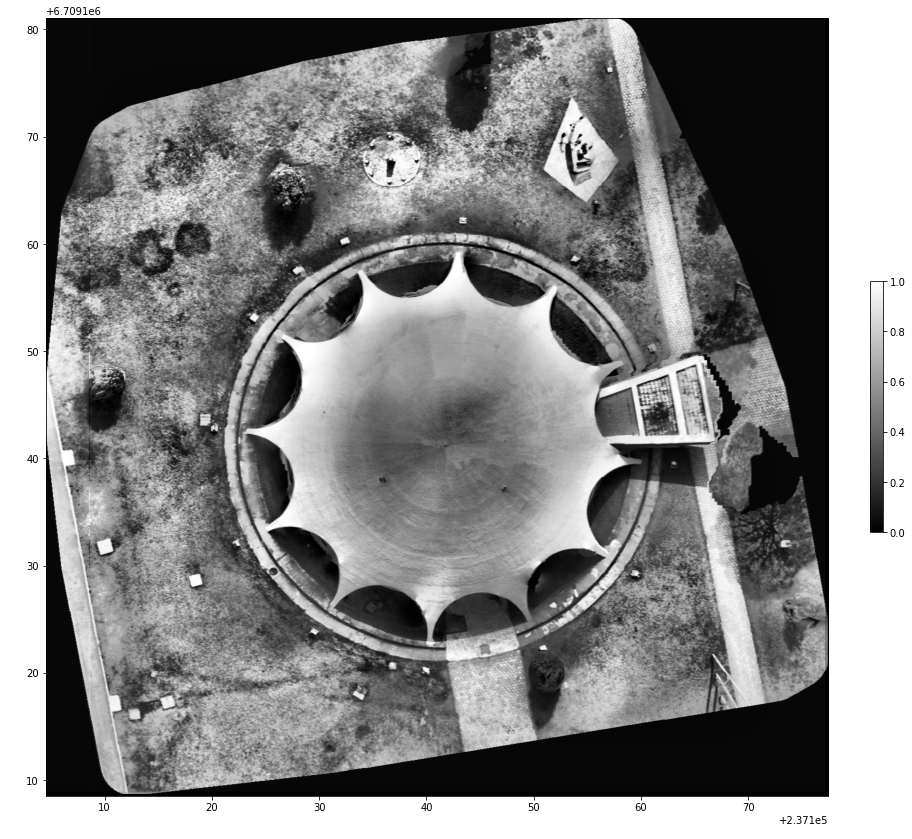

In [ ]:
# ---- FUNÇÔES ---
# ---- Filtro -- equalização -- Salvamento e Projeção
# Aplicação do filtro com a máscara escolhida acima
def frealce(filtro):
  filtro = scipy.signal.convolve2d(img, filtro, 'valid') 
  return filtro
filtrada = frealce(filtro)

# Ajuste do contraste da imagem filtrada com aplicação de uma Equalização de histograma
def equImage(filtrada):
  equalizada = exposure.equalize_adapthist(filtrada/np.max(np.abs(filtrada)), clip_limit=0.03)
  return equalizada

FILTRADA = equImage(filtrada)

# ----- Salvando os dados
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None
saveRaster(FILTRADA,path_GDALB,cols,rows,projection)

# ----- Plotando so dados
def plotRaster(rasterImage,extentArray,vmin,cmap):
    raster = gdal.Open(rasterImage)
    dsraster = raster.ReadAsArray()
    plt.figure(figsize=(15,15))
    im = plt.imshow(dsraster, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Leste', size=15,color='white')
    plt.ylabel('Sul', size=15,color='white',  rotation=90)
    plt.show()
plotRaster(path_GDALB,extentArray,0,'gray')


In [ ]:
driver = ogr.GetDriverByName("ESRI Shapefile")
data_source = driver.CreateDataSource("test.shp")
srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg)
layer = data_source.CreateLayer("test.shp",srs, geom_type=ogr.wkbPoint)

In [ ]:
# Criar ponto
ponto = ogr.Geometry(ogr.wkbPoint)
ponto.AddPoint(-49.00,-14.00)

In [ ]:
img = cv2.imread('FILTRADA.TIF',cv2.IMREAD_GRAYSCALE)